In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import time
import torch
from scipy.optimize import linprog
from qpsolvers import solve_qp
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.autograd import Function
import torch.nn as nn
from sklearn.model_selection import train_test_split
import sys
import StochasticGhost
import importlib
from torch.nn.utils import clip_grad_norm_
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from ... import StochasticGhost

2023-12-30 18:16:37.689425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-30 18:17:50.645032: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
raw_data = pd.read_csv("compas-scores-two-years.csv")

In [3]:
df = raw_data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) & (df['c_charge_degree'] != "O") & (df['score_text'] != 'N/A')]

In [4]:
df['length_of_stay'] = pd.to_datetime(
    df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['length_of_stay'] = df['length_of_stay'].dt.total_seconds() / 3600

In [5]:
df_needed = df[(df['race'] == 'Caucasian') | (df['race'] == 'African-American')]
race_mapping = {'African-American': 0, 'Caucasian': 1}

# Create a new column 'race_code' based on the mapping
df_needed['race_code'] = df_needed['race'].map(race_mapping)

/tmp/ipykernel_318/4134029126.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_needed['race_code'] = df_needed['race'].map(race_mapping)


In [6]:
# Categorizing
df_needed['crime_code'] = pd.Categorical(df_needed['c_charge_degree']).codes
df_needed['age_code'] = pd.Categorical(df_needed['age_cat']).codes
df_needed['race_code'] = df_needed['race'].map(race_mapping)
df_needed['gender_code'] = pd.Categorical(df_needed['sex']).codes
df_needed['score_code'] = pd.Categorical(df_needed['score_text']).codes
df_needed['charge_degree_code'] = pd.Categorical(
    df_needed['c_charge_degree']).codes

# Releveling factors
# df['age_factor'] = df['age_factor'].cat.reorder_categories(['Greater than 45', '25 - 45', 'Less than 25'], ordered=True)
# df['race_factor'] = df['race_factor'].cat.reorder_categories(['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other'], ordered=True)
# df['gender_factor'] = df['gender_factor'].cat.reorder_categories(['Female', 'Male'], ordered=True)

/tmp/ipykernel_318/1574350600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_needed['crime_code'] = pd.Categorical(df_needed['c_charge_degree']).codes
/tmp/ipykernel_318/1574350600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_needed['age_code'] = pd.Categorical(df_needed['age_cat']).codes
/tmp/ipykernel_318/1574350600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [7]:
in_df = df_needed[['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code']]
out_df = df_needed[['two_year_recid']]

In [8]:
blacks_in = len(df_needed[(df_needed['race_code'] == 0) & (df_needed['two_year_recid']== 0)])
whites_in = len(df_needed[(df_needed['race_code'] == 1) & (df_needed['two_year_recid'] == 0)])
print(blacks_in, whites_in)

1514 1281


In [9]:
class CustomNetwork(nn.Module):

    # For now the input data is passed as init parameters
    def __init__(self, layer_sizes, itrain, otrain, ival, oval, itrain_raw):
        super(CustomNetwork, self).__init__()

        # Create a list of linear layers based on layer_sizes
        self.itrain = itrain
        self.otrain = otrain
        self.ival = ival
        self.oval = oval
        self.itrain_raw = itrain_raw
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.sigmoid((layer(x)))
        x = torch.sigmoid(self.layers[-1](x))
        return x

    def compute_loss(self, Y, Y_hat):
        L_sum = 0.5*torch.sum(torch.square(Y - Y_hat))

        m = Y.shape[0]
        # print("Y shape is: ", m)
        L = (1./m) * L_sum

        return L

    def bce_loss(self, outputs, targets):
        criterion = nn.BCELoss()
        loss = criterion(outputs, targets)
        if torch.isnan(loss).any():
            for name, param in self.named_parameters():
                print(name)
                print(param.data)
        return loss

    def obj_fun(self, params, minibatch):
        model_parameters = list(self.parameters())
        x = self.itrain
        y = self.otrain
        #x_blacks = x[:, ]
        samples = np.random.choice(len(y), minibatch, replace=False)
        for i in range(len(params)):
            model_parameters[i].data = torch.Tensor(params[i])

        #print("LOOKIE:",x[samples, :])
        obj_fwd = self.forward(x[samples, :]).flatten()
        if torch.isnan(obj_fwd).any():
            for name, param in self.named_parameters():
                print(name)
                print(param.data)
        print("LOOKIE",obj_fwd)
        print(obj_fwd.shape)
        print(y[samples].shape)
        fval = self.bce_loss(obj_fwd, y[samples].flatten())
        print("Training loss is: ", fval)
        return fval.item()

    def obj_grad(self, params, minibatch):
        fgrad = []
        x = self.itrain
        y = self.otrain
        samples = np.random.choice(len(y), minibatch, replace=False)
        obj_fwd = self.forward(x[samples, :]).flatten()
        obj_loss = self.bce_loss(obj_fwd, y[samples].flatten())
        obj_loss.backward()

        #max_norm = 0.5
        #clip_grad_norm_(self.parameters(), max_norm)
        for param in self.parameters():
            if param.grad is not None:
                # Clone to avoid modifying the original tensor
                fgrad.append(param.grad.data.clone().view(-1))

        # Manually set gradients to zero
        for param in self.parameters():
            if param.grad is not None:
                param.grad.data.zero_()

        fgrad = torch.cat(fgrad, dim=0)
        return fgrad

# This constraint defines that difference between the Avg value of false positives for Blacks and Whites should be bounded by a certain number
    def conf_FP(self, params, minibatch):
        # print("Reached at function constraint")
        conf_val = None
        x_train = self.itrain
        y_train = self.otrain
        x_train_raw = self.itrain_raw
        #y_val_raw = self.oval_raw
        #print((x_val[:, 5] == 0) & (y_val.squeeze() == 0))
        x_blacks_0_lab = x_train[(x_train_raw[:, 4] == 0) & (y_train.squeeze() == 0), :]
        y_blacks_0_lab = y_train[(x_train_raw[:, 4] == 0) & (y_train.squeeze() == 0)]
        x_whites_0_lab = x_train[(x_train_raw[:, 4] == 1) & (y_train.squeeze() == 0), :]
        y_whites_0_lab = y_train[(x_train_raw[:, 4] == 1) & (y_train.squeeze() == 0)]
        black_samples = np.random.choice(len(y_blacks_0_lab), minibatch, replace=False)
        white_samples = np.random.choice(len(y_whites_0_lab), minibatch, replace=False)
        # conf_val = self.forward(x_val[minibatch, :])
        cons_fwd_black = self.forward(x_blacks_0_lab[black_samples, :]).flatten()
        print("The predictions for True lable 0 and blacks are", cons_fwd_black)
        print("Average is:", torch.mean(cons_fwd_black))
        #loss_black = self.compute_loss(cons_fwd_black, y_train[black_samples].flatten())
        mean_pred_black = torch.mean(cons_fwd_black)

        cons_fwd_white = self.forward(x_whites_0_lab[white_samples, :]).flatten()
        print("The predictions for True lable 0 and whites are", cons_fwd_white)
        print("Average is:", torch.mean(cons_fwd_white))
        #loss_white = self.compute_loss(cons_fwd_white, y_train[white_samples].flatten())
        mean_pred_white = torch.mean(cons_fwd_white)

        conf_val = torch.abs(mean_pred_black - mean_pred_white)

        print("Difference between mean: ", conf_val)

        # print("Validation loss is: ", conf_val)
        return conf_val.item()

    def conJ_FP(self, params, minibatch):
        # print("Reached at function constraint grad")
        x_train = self.itrain
        y_train = self.otrain
        x_train_raw = self.itrain_raw
        x_blacks_0_lab = x_train[(x_train_raw[:, 4] == 0) & (y_train.squeeze() == 0), :]
        print("Total no of blacks with y=0=",x_blacks_0_lab.shape[0])
        y_blacks_0_lab = y_train[(x_train_raw[:, 4] == 0) & (y_train.squeeze() == 0)]
        x_whites_0_lab = x_train[(x_train_raw[:, 4] == 1) & (y_train.squeeze() == 0), :]
        print("Total no of whites with y=0=", x_whites_0_lab.shape[0])
        y_whites_0_lab = y_train[(x_train_raw[:, 4] == 1) & (y_train.squeeze() == 0)]
        black_samples = np.random.choice(len(y_blacks_0_lab), minibatch, replace=False)
        white_samples = np.random.choice(len(y_whites_0_lab), minibatch, replace=False)
        cgrad = []
        # with torch.no_grad():
        cons_fwd_black = self.forward(x_blacks_0_lab[black_samples, :]).flatten()
        #loss_black = self.compute_loss(cons_fwd_black, y_train[black_samples])
        mean_pred_black = torch.mean(cons_fwd_black)

        cons_fwd_white = self.forward(x_whites_0_lab[white_samples, :]).flatten()
        #loss_white = self.compute_loss(cons_fwd_white, y_train[white_samples].flatten())
        mean_pred_white = torch.mean(cons_fwd_white)
        conf_val = torch.abs(mean_pred_black - mean_pred_white)
        conf_val.backward()
        #max_norm = 0.5
        #clip_grad_norm_(self.parameters(), max_norm)
        for param in self.parameters():
            if param.grad is not None:
                # Clone to avoid modifying the original tensor
                cgrad.append(param.grad.data.clone().view(-1))

# Manually set gradients to zero without using optimizer.zero_grad()
        for param in self.parameters():
            if param.grad is not None:
                param.grad.data.zero_()

        cgrad = torch.cat(cgrad, dim=0)

        return cgrad
    
#     def conf_FN(self, params, minibatch):
#         # print("Reached at function constraint")
#         conf_val = None
#         x_val = self.itrain
#         y_val = self.itrain
#         x_val_raw = self.ival_raw
#         # y_val_raw = self.oval_raw
#         # print((x_val[:, 5] == 0) & (y_val.squeeze() == 0))
#         x_blacks_1_lab = x_val[(x_val_raw[:, 5] == 0) & (y_val.squeeze() == 1), :]
#         y_blacks_1_lab = y_val[(x_val_raw[:, 5] == 0) & (y_val.squeeze() == 1)]
#         x_whites_1_lab = x_val[(x_val_raw[:, 5] == 1) & (y_val.squeeze() == 1), :]
#         y_whites_1_lab = y_val[(x_val_raw[:, 5] == 1) & (y_val.squeeze() == 1)]
#         black_samples = np.random.choice(
#             len(y_blacks_1_lab), minibatch, replace=False)
#         white_samples = np.random.choice(
#             len(y_whites_1_lab), minibatch, replace=False)
#         # conf_val = self.forward(x_val[minibatch, :])
#         cons_fwd_black = self.forward(x_blacks_1_lab[black_samples, :]).flatten()
#         loss_black = self.compute_loss(cons_fwd_black, y_val[black_samples].flatten())

#         cons_fwd_white = self.forward(x_whites_1_lab[white_samples, :]).flatten()
#         loss_white = self.compute_loss(cons_fwd_white, y_val[white_samples].flatten())

#         conf_val = (loss_black - loss_white)**2

#         # print("Validation loss is: ", conf_val)
#         return conf_val.item()
    
#     def conJ_FN(self, params, minibatch):
#         # print("Reached at function constraint grad")
#         x_train = self.itrain
#         y_train = self.otrain
#         x_val_raw = self.ival_raw
#         x_blacks_1_lab = x_train[(x_val_raw[:, 5] == 0) & (y_train.squeeze() == 1), :]
#         y_blacks_1_lab = y_train[(x_val_raw[:, 5] == 0) & (y_train.squeeze() == 1)]
#         x_whites_1_lab = x_train[(x_val_raw[:, 5] == 1) & (y_train.squeeze() == 1), :]
#         y_whites_1_lab = y_train[(x_val_raw[:, 5] == 1) & (y_train.squeeze() == 1)]
#         black_samples = np.random.choice(len(y_blacks_1_lab), minibatch, replace=False)
#         white_samples = np.random.choice(len(y_whites_1_lab), minibatch, replace=False)
#         cgrad = []
#         # with torch.no_grad():
#         cons_fwd_black = self.forward(x_blacks_1_lab[black_samples, :]).flatten()
#         loss_black = self.compute_loss(cons_fwd_black, y_train[black_samples])

#         cons_fwd_white = self.forward(x_whites_1_lab[white_samples, :]).flatten()
#         loss_white = self.compute_loss(cons_fwd_white, y_train[white_samples].flatten())
#         conf_val = (loss_black - loss_white)**2
#         conf_val.backward()
#         max_norm = 0.1
#         clip_grad_norm_(self.parameters(), max_norm)
#         for param in self.parameters():
#             if param.grad is not None:
#                 # Clone to avoid modifying the original tensor
#                 cgrad.append(param.grad.data.clone().view(-1))

# # Manually set gradients to zero without using optimizer.zero_grad()
#         for param in self.parameters():
#             if param.grad is not None:
#                 param.grad.data.zero_()

#         cgrad = torch.cat(cgrad, dim=0)

#         return cgrad
    


In [10]:
def paramvals(maxiter, beta, rho, lamb, hess, tau, mbsz, numcon, geomp, stepdecay, gammazero, zeta, N, n, lossbound):
    params = {
        'maxiter': maxiter,  # number of iterations performed
        'beta': beta,  # trust region size
        'rho': rho,  # trust region for feasibility subproblem
        'lamb': lamb,  # weight on the subfeasibility relaxation
        'hess': hess,  # method of computing the Hessian of the QP, options include 'diag' 'lbfgs' 'fisher' 'adamdiag' 'adagraddiag'
        'tau': tau,  # parameter for the hessian
        'mbsz': mbsz,  # the standard minibatch size, used for evaluating the progress of the objective and constraint
        'numcon': numcon,  # number of constraint functions
        'geomp': geomp,  # parameter for the geometric random variable defining the number of subproblem samples
        # strategy for step decrease, options include 'dimin' 'stepwise' 'slowdimin' 'constant'
        'stepdecay': stepdecay,
        'gammazero': gammazero,  # initial stepsize
        'zeta': zeta,  # parameter associated with the stepsize iteration
        'N': N,  # Train/val sample size
        'n': n,  # Total number of parameters
        'lossbound': lossbound #Bound on constraint loss
    }
    return params

In [14]:
#X_train = torch.tensor(xd.values)
#Y_train = torch.tensor(y)
# cons_bound = 10.
trials = 21
maxiter = 100
ftrial = np.zeros((maxiter, trials))
ctrial1 = np.zeros((maxiter, trials))
ctrial2= np.zeros((maxiter, trials))
initsaved = []
for trial in range(trials):
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>TRIAL", trial)
    x_train, x_val, y_train, y_val = train_test_split(in_df.values, out_df.values, test_size=0.2, random_state=42)
    ip_size = x_train.shape[1]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(x_train)
    X_val = scaler.transform(x_val)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    Y_val = torch.tensor(y_val, dtype=torch.float32)
    #print(type(X_train))
    hid_size1 = 16
    hid_size2 = 12
    op_size = 1
    #print(X_val.shape)
    #print(Y_val.shape)
    layer_sizes = [ip_size, hid_size1, hid_size2, op_size]
    #cond = (np.array(X_val)[:, 5] == 0) & (np.array(Y_val) == 0)
    #print(cond)
    #cond = (x_len == 1) & (Y_val == 0)
    #print(cond.shape)
    #print(Y_val.shape)
    # num_trials = min(len(y_val[((x_len)== 0) & (y_val.reshape(-1) == 0)]), len(y_val[(x_len == 1) & (y_val.reshape(-1) == 0)]), 
    #                  len(y_val[((x_len) == 0) & (y_val.reshape(-1) == 1)]), len(y_val[((x_len) == 1) & (y_val.reshape(-1) == 1)]))
    #x_len = x_val[:, 5]
    #num_trials = min(len(y_val[((x_len) == 0) & (y_val.reshape(-1) == 0)]), len(y_val[(x_len == 1) & (y_val.reshape(-1) == 0)]))
    
    x_len = x_train[:, 4]
    num_trials = min(len(y_train[((x_len) == 0) & (y_train.reshape(-1) == 0)]), len(y_train[(x_len == 1) & (y_train.reshape(-1) == 0)]))
    print(num_trials)
    #print(num_trials)
    net = CustomNetwork(
        layer_sizes, X_train[:, :ip_size], Y_train, X_val[:, :ip_size], Y_val, torch.tensor(x_train))
    print(net)
    # net.apply(net.init_weights)
    nn_parameters = list(net.parameters())
    # print(net)
    initw = [param.data for param in nn_parameters]
    # print(len(initw))
    num_param = sum(p.numel() for p in net.parameters())
    params = paramvals(maxiter=maxiter, beta=10., rho=20., lamb=20.0, hess='diag', tau=1., mbsz=10,
                       numcon=1, geomp=0.3, stepdecay='dimin', gammazero=0.1, zeta=0.1, N=num_trials, n=num_param, lossbound=[0.5])
    w, iterfs, itercs = StochasticGhost.StochasticGhost(
        net.obj_fun, net.obj_grad, [net.conf_FP], [net.conJ_FP], initw, params)
    ftrial[:, trial] = iterfs
    #print("The moment of TRUTH",itercs.shape)
    ctrial1[:, trial] = itercs[:,0]
    #ctrial2[:, trial] = itercs[:, 1]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>TRIAL 0
1036
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=12, bias=True)
    (2): Linear(in_features=12, out_features=1, bias=True)
  )
  (layer_norms): ModuleList()
)
LOOKIE tensor([0.6383, 0.6400, 0.6401, 0.6403, 0.6391, 0.6405, 0.6404, 0.6394, 0.6403,
        0.6392], grad_fn=<ViewBackward0>)
torch.Size([10])
torch.Size([10, 1])
Training loss is:  tensor(0.7335, grad_fn=<BinaryCrossEntropyBackward0>)
The predictions for True lable 0 and blacks are tensor([0.6392, 0.6390, 0.6392, 0.6403, 0.6376, 0.6401, 0.6393, 0.6380, 0.6387,
        0.6389], grad_fn=<ViewBackward0>)
Average is: tensor(0.6390, grad_fn=<MeanBackward0>)
The predictions for True lable 0 and whites are tensor([0.6394, 0.6400, 0.6386, 0.6392, 0.6390, 0.6401, 0.6393, 0.6397, 0.6407,
        0.6395], grad_fn=<ViewBackward0>)
Average is: tensor(0.6396, grad_fn=<MeanBackward0>)
Difference between mean

/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


LOOKIE tensor([0.1437, 0.1413, 0.1423, 0.1394], grad_fn=<ViewBackward0>)
torch.Size([4])
torch.Size([4, 1])
Training loss is:  tensor(0.5990, grad_fn=<BinaryCrossEntropyBackward0>)
<class 'numpy.ndarray'>
The predictions for True lable 0 and blacks are tensor([0.1430, 0.1401, 0.1414, 0.1428], grad_fn=<ViewBackward0>)
Average is: tensor(0.1418, grad_fn=<MeanBackward0>)
The predictions for True lable 0 and whites are tensor([0.1404, 0.1387, 0.1398, 0.1397], grad_fn=<ViewBackward0>)
Average is: tensor(0.1397, grad_fn=<MeanBackward0>)
Difference between mean:  tensor(0.0022, grad_fn=<AbsBackward0>)
Total no of blacks with y=0= 1199
Total no of whites with y=0= 1036
<class 'numpy.ndarray'>
LOOKIE tensor([0.0856, 0.0837, 0.0830, 0.0816, 0.0822, 0.0848, 0.0855, 0.0843, 0.0815,
        0.0846], grad_fn=<ViewBackward0>)
torch.Size([10])
torch.Size([10, 1])
Training loss is:  tensor(1.0443, grad_fn=<BinaryCrossEntropyBackward0>)
The predictions for True lable 0 and blacks are tensor([0.0853, 0.0

/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


Training loss is:  tensor(1.2819, grad_fn=<BinaryCrossEntropyBackward0>)
The predictions for True lable 0 and blacks are tensor([0.1260, 0.1295, 0.1327, 0.1295, 0.1319, 0.1297, 0.1321, 0.1269, 0.1266,
        0.1304], grad_fn=<ViewBackward0>)
Average is: tensor(0.1295, grad_fn=<MeanBackward0>)
The predictions for True lable 0 and whites are tensor([0.1306, 0.1317, 0.1309, 0.1319, 0.1306, 0.1322, 0.1316, 0.1357, 0.1317,
        0.1322], grad_fn=<ViewBackward0>)
Average is: tensor(0.1319, grad_fn=<MeanBackward0>)
Difference between mean:  tensor(0.0024, grad_fn=<AbsBackward0>)
LOOKIE tensor([0.1265], grad_fn=<ViewBackward0>)
torch.Size([1])
torch.Size([1, 1])
Training loss is:  tensor(0.1352, grad_fn=<BinaryCrossEntropyBackward0>)
<class 'numpy.ndarray'>
The predictions for True lable 0 and blacks are tensor([0.1311], grad_fn=<ViewBackward0>)
Average is: tensor(0.1311, grad_fn=<MeanBackward0>)
The predictions for True lable 0 and whites are tensor([0.1299], grad_fn=<ViewBackward0>)
Avera

/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix

tensor([0.1937], grad_fn=<ViewBackward0>)
Average is: tensor(0.1937, grad_fn=<MeanBackward0>)
Difference between mean:  tensor(0.0095, grad_fn=<AbsBackward0>)
Total no of blacks with y=0= 1199
Total no of whites with y=0= 1036
<class 'numpy.ndarray'>
LOOKIE tensor([0.2013, 0.1975, 0.2039, 0.2048, 0.1968, 0.1966, 0.1990, 0.1942, 0.2004,
        0.2013, 0.1950, 0.1990, 0.1956, 0.2011, 0.2023, 0.1936, 0.2038, 0.1959,
        0.1952, 0.1952, 0.1993, 0.2013, 0.1909, 0.1978, 0.1903, 0.2012, 0.2026,
        0.1960, 0.2060, 0.1994, 0.1942, 0.2013, 0.2008, 0.2023, 0.1960, 0.2000,
        0.2012, 0.2005, 0.1959, 0.1968, 0.1994, 0.1960, 0.1964, 0.1964, 0.1952,
        0.1968, 0.2031, 0.1925, 0.2023, 0.2013, 0.2041, 0.1968, 0.2041, 0.1968,
        0.2010, 0.1993, 0.1903, 0.2039, 0.2042, 0.1996, 0.2003, 0.1993, 0.2023,
        0.2028], grad_fn=<ViewBackward0>)
torch.Size([64])
torch.Size([64, 1])
Training loss is:  tensor(0.7681, grad_fn=<BinaryCrossEntropyBackward0>)
<class 'numpy.ndarray'>
The pr

/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/harsh/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


<class 'numpy.ndarray'>
LOOKIE tensor([0.1968, 0.1963, 0.1961, 0.1964, 0.1960, 0.1961, 0.1956, 0.1952, 0.1971,
        0.1960], grad_fn=<ViewBackward0>)
torch.Size([10])
torch.Size([10, 1])
Training loss is:  tensor(1.2062, grad_fn=<BinaryCrossEntropyBackward0>)
The predictions for True lable 0 and blacks are tensor([0.1961, 0.1973, 0.1961, 0.1976, 0.1959, 0.1954, 0.1962, 0.1958, 0.1961,
        0.1976], grad_fn=<ViewBackward0>)
Average is: tensor(0.1964, grad_fn=<MeanBackward0>)
The predictions for True lable 0 and whites are tensor([0.1962, 0.1958, 0.1954, 0.1960, 0.1958, 0.1971, 0.1961, 0.1976, 0.1958,
        0.1957], grad_fn=<ViewBackward0>)
Average is: tensor(0.1961, grad_fn=<MeanBackward0>)
Difference between mean:  tensor(0.0003, grad_fn=<AbsBackward0>)
LOOKIE tensor([0.1949], grad_fn=<ViewBackward0>)
torch.Size([1])
torch.Size([1, 1])
Training loss is:  tensor(1.6354, grad_fn=<BinaryCrossEntropyBackward0>)
<class 'numpy.ndarray'>
The predictions for True lable 0 and blacks are

In [185]:
for i in range(0, maxiter):
    ftrial[i, :] = np.sort(ftrial[i, :])
    ctrial1[i, :] = np.sort(ctrial1[i, :])
    #ctrial2[i, :] = np.sort(ctrial2[i, :])

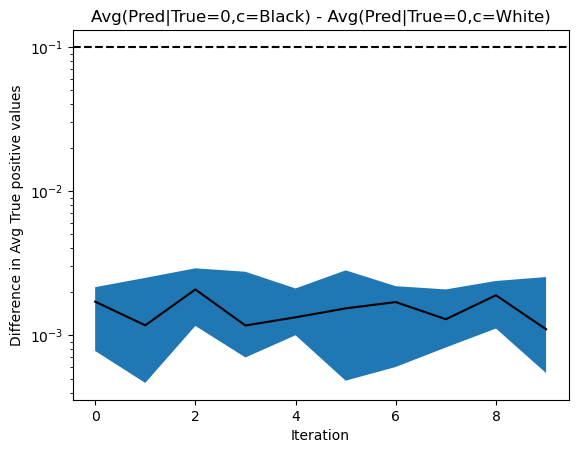

In [186]:
plt.plot(range(0, maxiter), ctrial1[:, 10], 'k-')
plt.fill_between(range(0, maxiter), ctrial1[:, 5], ctrial1[:, 15])
plt.axhline(y=0.1, color='black', linestyle='--', label='Horizontal Line at y=3')
# plt.plot(range(0, maxiter+1), convals[:, 0], 'k-')
# plt.fill_between(range(0, maxiter+1), convals[:, 0], convals[:, 1])
plt.title("Avg(Pred|True=0,c=Black) - Avg(Pred|True=0,c=White)")
plt.xlabel('Iteration')
plt.ylabel('Difference in Avg True positive values')
plt.yscale('log')

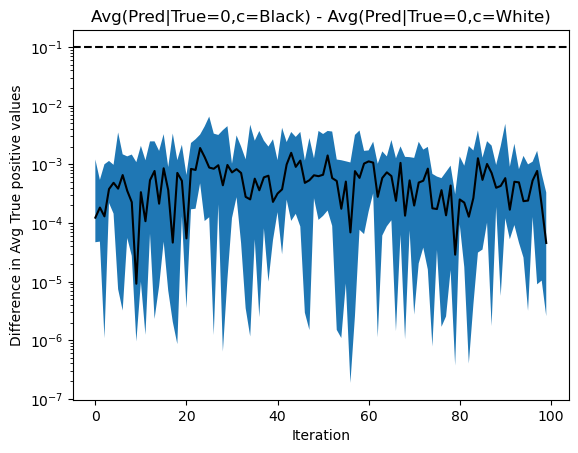

In [21]:
plt.plot(range(0, maxiter), ctrial2[:, 10], 'k-')
plt.fill_between(range(0, maxiter), ctrial2[:, 5], ctrial2[:, 15])
plt.axhline(y=0.1, color='black', linestyle='--',
            label='Horizontal Line at y=3')
# plt.plot(range(0, maxiter+1), convals[:, 0], 'k-')
# plt.fill_between(range(0, maxiter+1), convals[:, 0], convals[:, 1])
plt.title("Avg(Pred|True=0,c=Black) - Avg(Pred|True=0,c=White)")
plt.xlabel('Iteration')
plt.ylabel('Difference in Avg True positive values')
plt.yscale('log')

Text(0, 0.5, 'Loss')

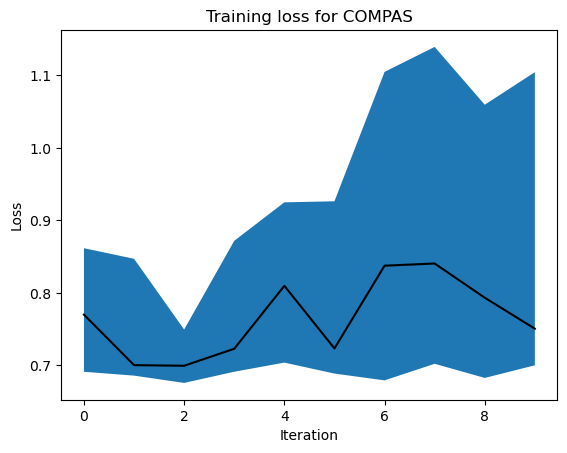

In [187]:
plt.plot(range(0, maxiter), ftrial[:, 10], 'k-')
plt.fill_between(range(0, maxiter), ftrial[:, 5], ftrial[:, 15])
# plt.plot(range(0, maxiter+1), convals[:, 0], 'k-')
# plt.fill_between(range(0, maxiter+1), convals[:, 0], convals[:, 1])
plt.title("Training loss for COMPAS")
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [188]:
x_len = x_val[:, 4]
#cond = (x_len == 1) & (Y_val == 0)
#print(cond.shape)
#print(Y_val.shape)
in_black_0_lab = X_val[((x_len)==0) & (y_val.reshape(-1) == 0)]
out_black_0_lab = Y_val[((x_len) == 0) & (y_val.reshape(-1) == 0)]
in_white_0_lab = X_val[(x_len == 1) & (y_val.reshape(-1) == 0)]
out_white_0_lab = Y_val[(x_len == 1) & (y_val.reshape(-1) == 0)]

In [189]:
in_black_1_lab = X_val[((x_len) == 0) & (y_val.reshape(-1) == 1)]
out_black_1_lab = Y_val[((x_len) == 0) & (y_val.reshape(-1) == 1)]
in_white_1_lab = X_val[(x_len == 1) & (y_val.reshape(-1) == 1)]
out_white_1_lab = Y_val[(x_len == 1) & (y_val.reshape(-1) == 1)]

In [190]:
print(in_black_0_lab.shape)

torch.Size([315, 7])


In [191]:
pred_b = net.forward(in_black_0_lab)
torch.mean(pred_b)

tensor(0.4396, grad_fn=<MeanBackward0>)

In [192]:
pred_b_2 = net.forward(in_black_1_lab)
torch.mean(pred_b_2)

tensor(0.4404, grad_fn=<MeanBackward0>)

In [193]:
pred_w = net.forward(in_white_0_lab)
torch.mean(pred_w)

tensor(0.4419, grad_fn=<MeanBackward0>)

In [194]:
pred_w_2 = net.forward(in_white_1_lab)
torch.mean(pred_w_2)

tensor(0.4422, grad_fn=<MeanBackward0>)

In [108]:
print(Y_val.shape)

torch.Size([1056, 1])


In [195]:
outputs = net.forward(X_val)
predictions = (outputs >= 0.5).float()
print(predictions.shape)

torch.Size([1056, 1])


In [196]:
print(torch.sum(Y_val.flatten() == predictions.flatten()).item() / len(predictions.flatten()))

0.5303030303030303


In [200]:
fp_white_condition = (predictions.flatten() == 1) & (y_val.reshape(-1) == 0) & (x_val[:, 4] == 1)
fp_white = np.count_nonzero(fp_white_condition)
print("False positives in white:", fp_white)
p_white_condition = (y_val.reshape(-1) == 1) & (x_val[:, 4] == 1)
p_white = np.count_nonzero(p_white_condition)
print("Total positives in white:", p_white)
print("False positive rate in white:", fp_white/p_white)

False positives in white: 0
Total positives in white: 168
False positive rate in white: 0.0


In [201]:
fp_black_condition = (predictions.flatten() == 1) & (y_val.reshape(-1) == 0) & (x_val[:, 4] == 0)
fp_black = np.count_nonzero(fp_black_condition)
print("False positives in black:", fp_black)
p_black_condition = (y_val.reshape(-1) == 1) & (x_val[:, 4] == 1)
p_black = np.count_nonzero(p_black_condition)
print("Total positives in black:", p_black)
print("False positive rate in black:", fp_black/p_black)

False positives in black: 0
Total positives in black: 168
False positive rate in black: 0.0


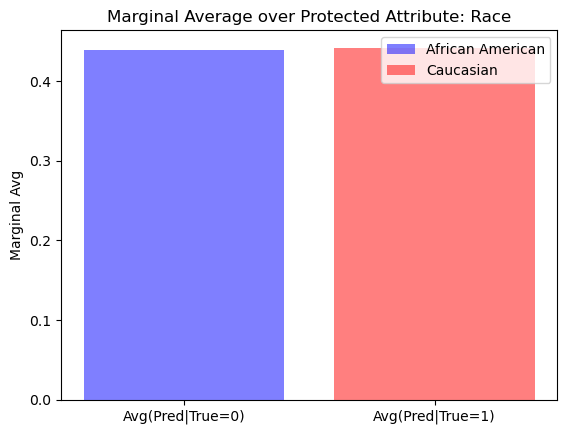

In [202]:
colors = ['blue', 'red']
labels = ['African American', 'Caucasian']
plt.bar(['Avg(Pred|True=0)', 'Avg(Pred|True=1)'], [torch.mean(pred_b).item(), torch.mean(pred_w).item()], color=colors, alpha=0.5, label = labels)
#plt.xticks(rotation=45, ha='right')
plt.ylabel('Marginal Avg')
plt.title('Marginal Average over Protected Attribute: Race')
plt.legend()

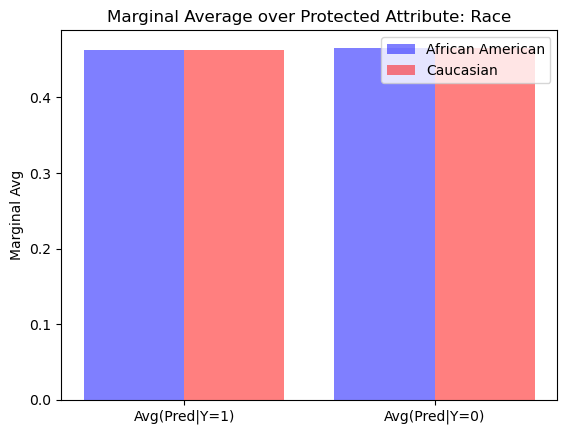

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Avg(Pred|Y=1)', 'Avg(Pred|Y=0)']
values1 = [torch.mean(pred_b).item(), torch.mean(pred_w).item()]
values2 = [torch.mean(pred_b_2).item(), torch.mean(pred_w_2).item()]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories))

# Plot the first group of bars (Bars 1 and 2)
plt.bar(index, values1, color='blue', width=bar_width,
        label='African American', alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
plt.bar(index + bar_width, values2, color='red',
        width=bar_width, label='Caucasian', alpha=0.5)

# Adjust the x-axis ticks and labels
plt.xticks(index + bar_width / 2, categories)

# Add labels and legend
# plt.xlabel('Categories')
plt.ylabel('Marginal Avg')
plt.title('Marginal Average over Protected Attribute: Race')
plt.legend()

# Show the plot
plt.show()